Exercice initialement proposé par Élodie Puybareau, remis en forme par Guillaume Tochon

In [1]:
### Importing libraires ###
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
# Matplotlib in inline mode
%matplotlib inline

# Localisation de l'origine d'un séisme par intercorrélation

Dans cet exercice, vous aller exploiter la fonction d'intercorrélation pour trianguler l'épicentre d'un séisme. C'est une problématique de reconnaissance de motif : vous allez chercher à localiser un motif connu dans un signal déterioré (à cause du bruit, de dégradations parasites, etc)

## Un peu de contexte... 

Vous êtes un chercheur du CNRS spécialisé en tremblement de terre. Un tremblement de terre vient justement de se produire quelque part dans le monde, et vous voulez savoir où. Vous vous connectez donc à votre réseau de sondes éparpillées sur la Terre entière afin de récupérer les données des sismographes, et à l'aide de triangulation, déterminer l'origine du séisme en question. 

Malheureusement, du fait de plusieurs coupes budgétaires successives au sein du CNRS, vous ne disposez que de 3 sondes, de qualités inégales, dont voici les principales caractéristiques :

* **Sonde 1** : Localisée à Paris, pas très loin de votre bureau. C'est la sonde la plus performante et précise, car la mieux entretenue des 3. Elle enregistre une valeur toutes les 0.5 secondes. De plus, elle est dans un endroit bien protégé et isolé, elle est donc très peu soumise aux interférences extérieures.

* **Sonde 2** : Localisé à Sao Paulo. Elle est deux fois moins précise que la sonde de Paris, puisqu'elle enregistre une valeur par seconde. Elle n'est pas très bien isolée, et malheureusement, le technicien en charge de sa maintenance avait sa fille de 3 ans qui faisait de la corde à sauter avec lui au moment du tremblement de terre...

* **Sonde 3** : Localisé à Sidney. C'est la pire des sondes (en même temps, la majorité du budget qui lui était alloué a été dépensé dans le billet d'avion que vous avez acheté pour aller l'installer...). Elle enregistre une valeur toutes les 2 secondes, et en plus le métro passe juste en dessous, provoquant beaucoup de tremblements parasites.

## Quelques bases de sismologie

On va considérer 2 types d'[ondes sismiques](https://fr.wikipedia.org/wiki/Onde_sismique) : les ondes P (horizontales, les plus rapides) et les ondes S (qui arrivent en 2e). 

Pour une station, on peut écrire :
* *Temps d’arrivée de l’onde P* : $$t_P = t_0 + \displaystyle\frac{d}{v_P}$$
* *Temps d’arrivée de l’onde S* : $$t_S = t_0 + \displaystyle\frac{d}{v_S}$$

où $d$ est la distance à l'épicentre, $t_0$ le moment du séisme, $v_P$ la vitesse des ondes $P$ et $v_S$ la vitesse des ondes $S$ (avec $v_P > v_S$, les ondes $P$ se déplaçant plus rapidement que les ondes $S$).

<b>Problème :</b> on ne connaît pas $t_0$ car on a uniquement les relevés de nos 3 sondes ! Pour chacune des sondes, on va alors isoler la distance $d$ en faisant la différence entre les deux relations précédentes : $$t_S - t_P = d × \left(\displaystyle\frac{1}{v_S} - \displaystyle\frac{1}{v_P}\right)$$

On admettra que $\left(\displaystyle\frac{1}{v_S} - \displaystyle\frac{1}{v_P}\right) = \displaystyle \frac{1}{8} \text{ s.km}^{-1}$

Pour une station donné, on obtient au final l'estimation de sa distance $d$ à l'épicentre par la formule : $d = 8 × (t_S - t_P)$<br>
où $d$ est exprimé en km et $t_S - t_P$ en secondes.

Pour chaque station, on a donc uniquement besoin de connaître le temps qui s'est écoulé entre l'arrivée de l'onde $P$ et de l'onde $S$ ! Cela nous donne la distance entre l'épicentre et la sonde : l'épicentre se situe sur un cercle de rayon $d$ centré sur la sonde. En faisant ce calcul pour 3 sondes, on obtient un unique point au croisement de ces 3 cercles : l'origine de notre séisme !

<br>

<div style="display: flex;">
    <a href="https://www.mtu.edu/geo/community/seismology/learn/earthquake-epicenter/images/example-seismograms-orig.jpg" target="_blank"><img src="https://www.mtu.edu/geo/community/seismology/learn/earthquake-epicenter/images/example-seismograms-orig.jpg" width="800"></a>
    <a href="https://www.mtu.edu/geo/community/seismology/learn/earthquake-epicenter/images/epicenter-by-intersection-orig.jpg" target="_blank"><img src="https://www.mtu.edu/geo/community/seismology/learn/earthquake-epicenter/images/epicenter-by-intersection-orig.jpg" width="945"></a>
</div>


On considèrera que la distance $d$ est environ égale à la distance à vol d'oiseau entre la sonde et l'épicentre. Il y a 6 candidats pour l'épicentre :

| Candidat | Distance Sonde 1 | Distance Sonde 2 | Distance Sonde 3 |
|----------|------------------|------------------|------------------|
| New York | 5800 km          | 7700 km          | 16000 km
| Tokyo    | 9700 km          | 18500 km         | 7800 km
| Moscou   | 2500 km          | 11800 km         | 14000 km
| Impfondo         | 5800 km          | 7700 km          |  14000 km
| Ninghua    | 9700 km          | 18500 km          | 7600 km
| Quelque part au large du Groenland         | 2500 km          | 11800 km          | 16000 km




Pour commencer, définissons les templates des ondes P et S qui vous serviront pour la suite.<br>
P1 et S1 correspondent aux signaux P et S avec la résolution de la sonde 1, P2 et S2 pour la sonde 2 et P3 et S3 pour la sonde 3.

In [4]:
# 🛑 define generic P wave template
def template_P_wave(probe_resolution=1,fe=125,tmin=0,tmax=15):
    t0 = 1.2
    Te = probe_resolution/fe
    t = np.arange(tmin,tmax,Te)
    p_wave = np.exp(-t/t0)*np.sin(2*np.pi*t)
    return t,p_wave

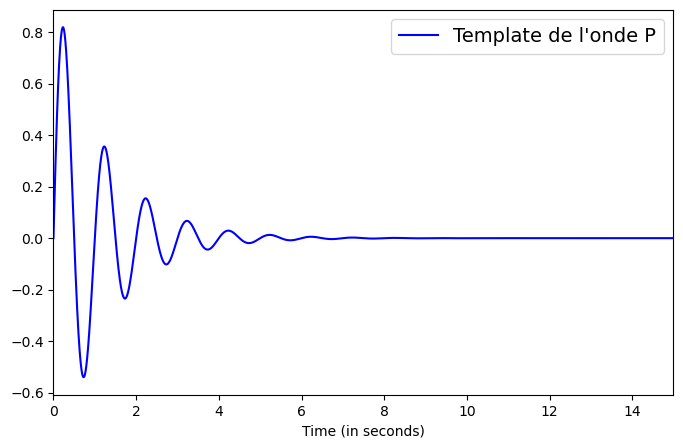

In [5]:
# 🛑 define P wave templates for all 3 probes with their temporal resolution
t1,P1 = template_P_wave(probe_resolution=0.5)
t2,P2 = template_P_wave(probe_resolution=1)
t3,P3 = template_P_wave(probe_resolution=2)

plt.figure(figsize=(8,5))
plt.plot(t1,P1,'b',label="Template de l'onde P")
plt.xlim((t1.min(),t1.max()))
plt.xlabel('Time (in seconds)')
plt.legend(loc='upper right',fontsize=14)
plt.show()

In [6]:
# 🛑 define generic S wave template
def template_S_wave(probe_resolution=1,fe=125,tmin=0,tmax=15):
    t0 = 1.2
    Te = probe_resolution/fe
    t = np.arange(tmin,tmax,Te)
    s_wave = np.exp(-0.5*t/t0)*np.sin(5*np.pi*t)
    return t,s_wave

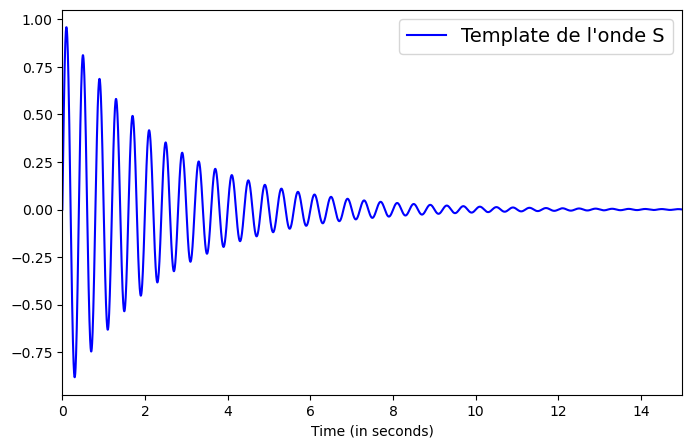

In [7]:
# 🛑 define S wave templates for all 3 probes with their temporal resolution
_,S1 = template_S_wave(probe_resolution=0.5)
_,S2 = template_S_wave(probe_resolution=1)
_,S3 = template_S_wave(probe_resolution=2)

plt.figure(figsize=(8,5))
plt.plot(t1,S1,'b',label="Template de l'onde S")
plt.xlim((t1.min(),t1.max()))
plt.xlabel('Time (in seconds)')
plt.legend(loc='upper right',fontsize=14)
plt.show()

### L'objectif de cet exercice : retrouver l'épicentre du séisme !

Dans le dossier "signaux", vous avez les signaux enregistrés par les 3 sondes.

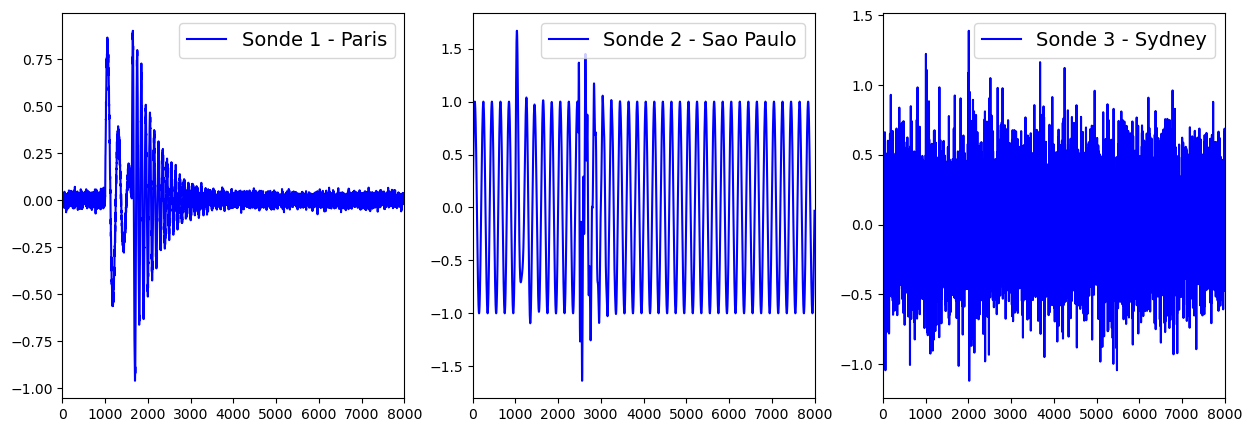

In [8]:
# 🛑 Loading the signals recorded by the 3 probes
Sonde_1 = np.load("signaux/sonde1.npy")
Sonde_2 = np.load("signaux/sonde2.npy")
Sonde_3 = np.load("signaux/sonde3.npy")
# plotting the signals
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(Sonde_1,'b',label='Sonde 1 - Paris')
plt.xlim(0,Sonde_1.size)
plt.legend(loc='best',fontsize=14)
plt.subplot(132)
plt.plot(Sonde_2,'b',label='Sonde 2 - Sao Paulo')
plt.xlim(0,Sonde_2.size)
plt.legend(loc='best',fontsize=14)
plt.subplot(133)
plt.plot(Sonde_3,'b',label='Sonde 3 - Sydney')
plt.xlim(0,Sonde_3.size)
plt.legend(loc='best',fontsize=14)
plt.show()

<i> Notez que dans les graphs ci-dessus, l'échelle de l'abscisse représente un nombre de points et non une durée en seconde. Mais les notices des sondes vous donnent la résolution temporelle des sondes, donc vous pouvez aisément convertir les abscisses en secondes.<br>
Notez également que les échelles de temps sont totalement fantaisistes. Par exemple pour Sao Paulo, le signal fait 8000 points, à une résolution de 1 point/s. Soit un enregistrement de 8000/3600 = 2h13 (la fille du technicien est donc sacrément endurante...). Malgré tout, ces échelles de temps permettent de simplifier un peu le problème, et n'impactent absolument pas la méthode de résolution.</i>

### 🛠️ 🚧 👷  À vous de jouer !

Commençons par traiter le signal issu de la sonde 1 (celle de Paris).
À vous de jouer :
1. Calculez (et tracez) l'intercorrélation entre le signal issu de la sonde, et le template $P1$ (le template de l'onde $P$, à la même résolution temporelle que le signal issu de la sonde 1)
2. Déterminez le retard (en nombre de points) de l'onde P1 dans le signal de la sonde 1 (vous pouvez vous servir de [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) pour cela)
3. Convertissez ce retard en nombre de point en un retard en seconde, en vous servant de la résolution de la sonde 1. Vous obtiendrez donc $t_{P1}$
4. Répétez les étapes 1, 2 et 3 pour S1 (le template de l'onde $S$ à la même résolution temporelle que le signal issu de la sonde 1). Vous obtiendrez donc $t_{S1}$
5. Utilisez la formule donnée $d_1 = 8 × (t_{S1} - t_{P1})$ pour en déduire la distance de l'épicentre à la sonde 1

#### Pour l'onde P1
À vous d'appliquer les étapes 1 à 3

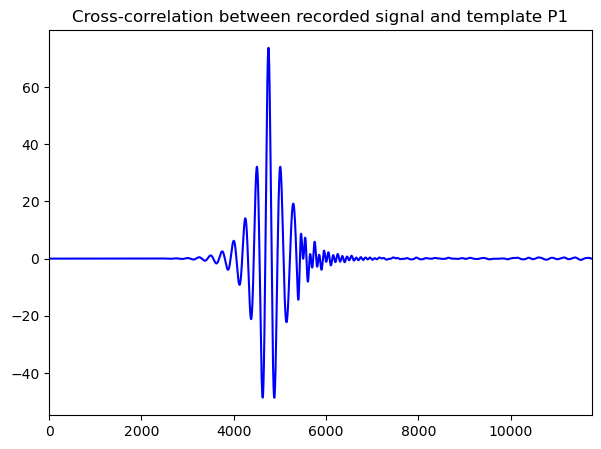

In [10]:
corr_p1 = sp.signal.correlate(Sonde_1, P1) # FIXME

# plotting crosscorrelation between signal of probe 1 and template P1
plt.figure(figsize=(7,5))
plt.plot(corr_p1,'b')
plt.title('Cross-correlation between recorded signal and template P1')
plt.xlim(0,corr_p1.size)
plt.show()

In [18]:
delay_p1 = np.argmax(corr_p1)# FIXME (delay in number of points)
print("Temps estimé pour P1 : %1.1f (en nombre de points)"%delay_p1)

t_p1 = delay_p1 * 0.5 # FIXME (delay in second)
print("Temps estimé pour P1 : %1.1f (en secondes)"%t_p1)

Temps estimé pour P1 : 4750.0 (en nombre de points)
Temps estimé pour P1 : 2375.0 (en secondes)


#### Pour l'onde S1
À vous de répétez les étapes précédentes en modifiant de manière adéquate le code pour déterminer le délai de l'onde S

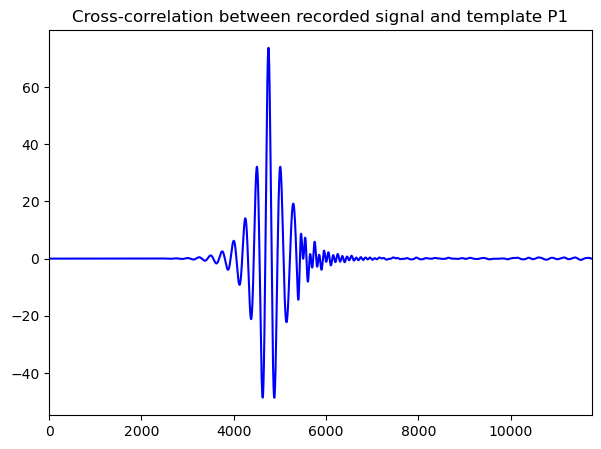

Temps estimé pour P1 : 5374.0 (en nombre de points)
Temps estimé pour P1 : 2687.0 (en secondes)


In [20]:
corr_S1 = sp.signal.correlate(Sonde_1, S1) # FIXME

# plotting crosscorrelation between signal of probe 1 and template P1
plt.figure(figsize=(7,5))
plt.plot(corr_p1,'b')
plt.title('Cross-correlation between recorded signal and template P1')
plt.xlim(0,corr_p1.size)
plt.show()

delay_S1 = np.argmax(corr_S1) # FIXME (delay in number of points)
print("Temps estimé pour P1 : %1.1f (en nombre de points)"%delay_S1)

t_S1 = delay_S1 * 0.5 # FIXME (delay in second)
print("Temps estimé pour P1 : %1.1f (en secondes)"%t_S1)

#### Distance finale
Déterminez maintenant la distance de la sonde 1 à l'épicentre. Quels sont les candidats potentiels pour l'épicentre ?

In [21]:
d1 = 8 * (t_S1 - t_p1) # FIXME
print("Distance de la sonde 1 à l'épicentre : %1.1f (en kilomètres)"%d1)

Distance de la sonde 1 à l'épicentre : 2496.0 (en kilomètres)


 Candidats potentiels pour l'épicentre : GROENLAND MOSCOW

### 🛠️ 🚧 👷  À vous de jouer !

Appliquer la même procédure pour traiter le signal issu de la sonde 2 (celle de Sao Paulo), puis déduisez-en la distance de la sonde 2 à l'épicentre. Quels sont les nouveaux lieux candidats ?

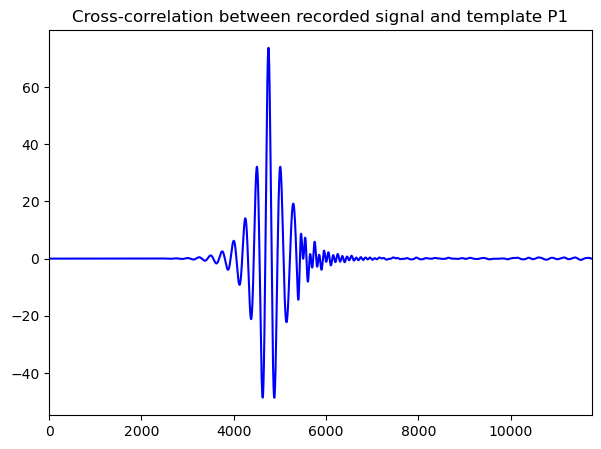

Temps estimé pour P1 : 4750.0 (en nombre de points)
Temps estimé pour P1 : 2375.0 (en secondes)


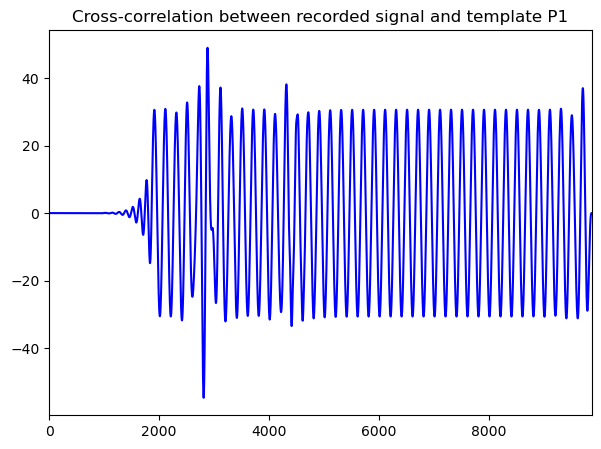

Temps estimé pour P2 : 4349.0 (en nombre de points)
Temps estimé pour P2 : 4349.0 (en secondes)
Distance de la sonde 2 à l'épicentre : 11720.0 (en kilomètres)


In [26]:
corr_p2 = sp.signal.correlate(Sonde_2, P2) # FIXME

# plotting crosscorrelation between signal of probe 1 and template P1
plt.figure(figsize=(7,5))
plt.plot(corr_p1,'b')
plt.title('Cross-correlation between recorded signal and template P1')
plt.xlim(0,corr_p1.size)
plt.show()

delay_p2 = np.argmax(corr_p2)# FIXME (delay in number of points)
print("Temps estimé pour P1 : %1.1f (en nombre de points)"%delay_p1)

t_p2 = delay_p2 # FIXME (delay in second)
print("Temps estimé pour P1 : %1.1f (en secondes)"%t_p1)

corr_S2 = sp.signal.correlate(Sonde_2, S2) # FIXME

# plotting crosscorrelation between signal of probe 1 and template P1
plt.figure(figsize=(7,5))
plt.plot(corr_p2,'b')
plt.title('Cross-correlation between recorded signal and template P1')
plt.xlim(0,corr_p2.size)
plt.show()

delay_S2 = np.argmax(corr_S2) # FIXME (delay in number of points)
print("Temps estimé pour P2 : %1.1f (en nombre de points)"%delay_S2)

t_S2 = delay_S2# FIXME (delay in second)
print("Temps estimé pour P2 : %1.1f (en secondes)"%t_S2)

d2 = 8 * (t_S2 - t_p2) # FIXME
print("Distance de la sonde 2 à l'épicentre : %1.1f (en kilomètres)"%d2)

Nouveaux candidats potentiels pour l'épicentre : GROENLAND MOSCOW

### 🛠️ 🚧 👷  À vous de jouer !

Rebelote avec le signal issu de la sonde 3 (Sydney), et déduisez-en la distance de la sonde 3 à l'épicentre. Quelle était l'origine du séisme ?

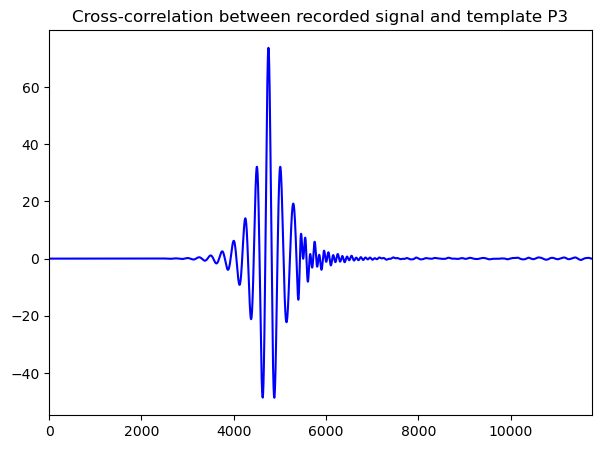

Temps estimé pour P3 : 1938.0 (en nombre de points)
Temps estimé pour P3 : 2375.0 (en secondes)


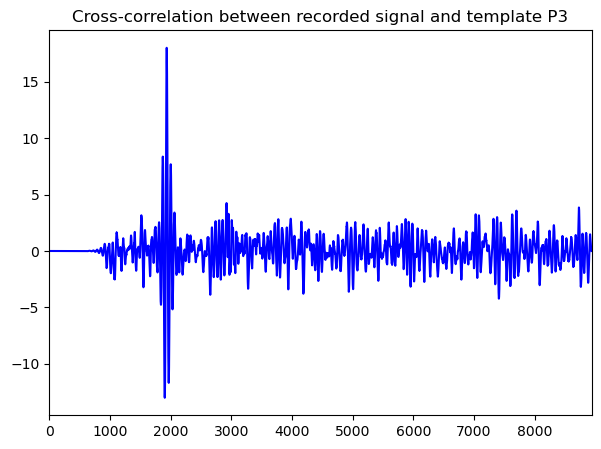

Temps estimé pour P3 : 4349.0 (en nombre de points)
Temps estimé pour P3 : 4349.0 (en secondes)
Distance de la sonde 3 à l'épicentre : 15984.0 (en kilomètres)


In [27]:
corr_p3 = sp.signal.correlate(Sonde_3, P3) # FIXME

# plotting crosscorrelation between signal of probe 1 and template P3
plt.figure(figsize=(7,5))
plt.plot(corr_p1,'b')
plt.title('Cross-correlation between recorded signal and template P3')
plt.xlim(0,corr_p1.size)
plt.show()

delay_p3 = np.argmax(corr_p3)# FIXME (delay in number of points)
print("Temps estimé pour P3 : %1.1f (en nombre de points)"%delay_p3)

t_p3 = delay_p3 * 2 # FIXME (delay in second)
print("Temps estimé pour P3 : %1.1f (en secondes)"%t_p1)

corr_S3 = sp.signal.correlate(Sonde_3, S3) # FIXME

# plotting crosscorrelation between signal of probe 1 and template P3
plt.figure(figsize=(7,5))
plt.plot(corr_p3,'b')
plt.title('Cross-correlation between recorded signal and template P3')
plt.xlim(0,corr_p3.size)
plt.show()

delay_S3 = np.argmax(corr_S3) # FIXME (delay in number of points)
print("Temps estimé pour P3 : %1.1f (en nombre de points)"%delay_S2)

t_S3 = delay_S3 * 2# FIXME (delay in second)
print("Temps estimé pour P3 : %1.1f (en secondes)"%t_S2)

d3 = 8 * (t_S3 - t_p3) # FIXME
print("Distance de la sonde 3 à l'épicentre : %1.1f (en kilomètres)"%d3)

L'épicentre du séisme est donc : GROENLAND

# Bravo !
Grâce à votre excellent travail et au nouveau financement que vous venez de récupérer, vous allez pouvoir embaucher <s>de la main d'œuvre pas chère</s> un nouveau thésard. Vous pouvez maintenant passer au dernier exercice de ce TP : [le produit de convolution](TP1_correlation_convolution_exo3.ipynb)